# Adversarial Attacks

### Background

Adversarial attacks are a method of generating inputs to a machine learning model intentionally designed to cause a mistake in its predictions. These inputs should be able to fool the model and may resemble a valid input, possibly such that a human would would classify it as the original input. Such attacks could have ramifications on deployed models. For example, one would not want stickers placed on a sign to mislead an autonomous driving system into making dangerous decisions or for imperceptible noise in an image to change predictions \[[1](https://arxiv.org/abs/1707.08945)\].

### The Black-Box Setting

We explore the setting of black-box attacks in which the attacker has no knowledge of the classifier, thereby limiting the method of attack [\[2\]](https://ieeexplore.ieee.org/document/9001114). This is in contrast to white-box attacks where attackers may have knowledge of the training data, model parameters, model structure, and other related information. Given the limited information, black-box attacks may only query the model, and many versions seek to estimate a gradient-based objective through these queries. No other knowledge of the model is a realistic assumption, for example, in settings where a trained machine learning tool may be deployed in production.

### Metrics

Given that the goal is to produce a sample as close to a realistic input as possible, these gradient-based black-box attacks must include an objective function with some notion of similarity between the original and adversarial samples. This is frequently expressed in the form of an $l_p$ distance such that:

$$||x-y||_p = \left( \sum_{i=1}^n (|x_i - y_i|)^p \right)^{1/p}$$

where $x$ and $y$ are the original and adversarial samples, respectively, $n$ is the number of features, and $p \in \{0, 2, \infty \}$. Note that the $l_\infty$ norm is equivalent to:

$$||x-y||_\infty = \max \{ |x_1 - y_1|, |x_2 - y_2|, ..., |x_n - y_n|\}$$


Inclusion of $l_p$ norm provides different interpretations of the attack objectives:

- $l_\infty (x,y)$: Promotes minimizing the maximum amount of perturbation to any input feature
- $l_2 (x,y)$: Promotes minimizing the Euclidean distance between original and adversarial samples
- $l_0 (x,y)$: Promotes minimizing the number of features perturbed

The goal of these attacks are to produce samples that change the classification while remaining similar to the original sample. Therefore, these attacks should minimize at least one of such similarity metrics. Accordingly, many proposed black box attacks report the average $l_2$ and/or $l_\infty$ distance of the generated aversarial samples to indicate improvement, as a smaller successful perturbation, over other attacking methods \[[3](https://arxiv.org/abs/1904.02144), [4](https://arxiv.org/abs/1708.03999), [5](https://arxiv.org/abs/2003.06468), [6](https://arxiv.org/abs/1905.07121)\]. Models that are suggested to be more robust to adversarial attacks include at least one of the $l_2$ or $l_\infty$ distances, but also include a metric that indicates success of the attack under the original classification model, such as classification error, attack success rate, rate of fooling, or defense success rate \[[7](https://arxiv.org/abs/2109.05820), [8](https://arxiv.org/abs/2103.03438), [9](https://arxiv.org/abs/1902.10660), [10](https://arxiv.org/abs/2102.12002)\]. Therefore, this experiment analyzes the average $l_2$ and $l_\infty$ distances, and reports the average classification error of the adversarial samples over multiple trials.

# Attacking Kernel Density Forest (KDF) and Random Forest (RF)

As previously mentioned, black-box models rely on querying the decision space. Machine learning models, like RF, tend to be overconfident in out of distribution regions that extend infinitely. In contrast, KDF's posterior probabilities are well calibrated to the distribution of the training data. Therefore, we are interested in comparing performance of RF and KDF under black-box attacks. In particular, we use the [HopSkipJump Attack](https://arxiv.org/abs/1904.02144) implementation provided from the [adversarial-robustness-toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox) \[[3](https://arxiv.org/abs/1904.02144)\]. Hop Skip Jump proposes a "novel unbiased estimate of gradient direction at the decision boundary based solely on access to model decisions" \[[3](https://arxiv.org/abs/1904.02144)\]. At a high level, this algorithm explores where the classification boundaries are, estimates the direction of the gradient at the boundary, and then takes a small step in that direction. It is similar to the popular [Zeroth Order Optimization (ZOO)](https://arxiv.org/abs/1708.03999), but is more query efficient and less computationally intense \[[4](https://arxiv.org/abs/1708.03999)\]. 

In [ ]:
# Created by: Jacob Desman
# Date: 2022-05-09
# Contact at: jake.m.desman@gmail.com

In [1]:
from kdg.utils import generate_gaussian_parity
from kdg import kdf
import pandas as pd
from joblib import Parallel, delayed

from functions.kdf_adversarial import get_adversarial_examples
from functions.kdf_adversarial import combine_results
from functions.kdf_adversarial import plot_attack
from functions.kdf_adversarial import experiment

## Intuition

To visualize how such attacks work in low dimension, an example is shown on the 2D Gaussian XOR Distribution. Note that this is a poor distribution for an adversarial attack intended to fool humans; there is no way to generate an adversarial sample that a human would designate as the original class, but it is instead meant to provide intuition for how such attacks work. Here, one would expect points to be moved just beyond the decision thresholds where each of the partitions meet. 

In [2]:
n_classes = 2
n_samples = 1000
n_attack = 10  
x_train, y_train = generate_gaussian_parity(n_samples, cluster_std=0.25)

model = kdf()
model.fit(x_train, y_train)
x_train_adv_kdf, idx, model = get_adversarial_examples(
    model, x_train, n_attack=n_attack, nb_classes=n_classes
)

HopSkipJump: 100%|██████████| 10/10 [06:04<00:00, 36.48s/it]


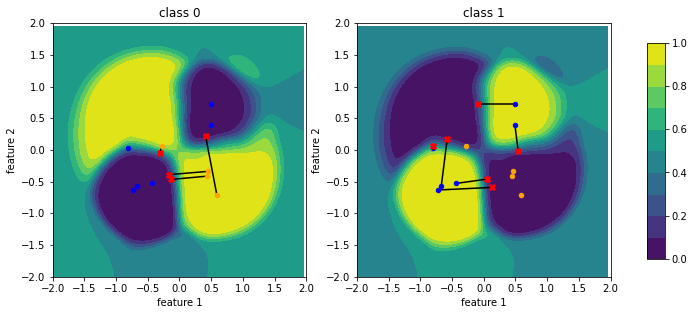

In [3]:
plot_attack(model, x_train[idx], y_train[idx], x_train_adv_kdf, n_classes)

Here, the colored background represents the probability of class $i$ corresponding to the panel title. The orange circles are class $0$ and the blue circles are class $1$. Red crosses are the adversarial samples for class $i$ denoted in the panel title. 

Again, while the Gaussian XOR simulation is not a realistic target for adversarial attacks, it illustrates the intuition of how such attacks work. Adversarial attacks generally seek to perturb points the smallest possible distance beyond the decision threshold, and this attack has appears to have found a low the $l_2$ distance perturbation required to fool the model.

# OpenML Experiments

We hypothesize that the well-formed posteriors of KDF make it more difficult to find the boundaries required to flip decisions.

This experiment seeks to analyze the classification error and perturbation size of adversarial samples. Classification error is reported as the proportion of adversarial samples that successfully fool the model. Therefore, identifying the sample as the original class of the adversarial sample will lower classification error. Perturbation size is measured as the average $l_2$ and $l_\infty$ distance between the original and adversarial samples across all attacked points. Additionally, $\Delta = KDF - RF$ for each of the metrics is reported. Ideally, KDF will have a negative $\Delta$ for each of the metrics, indicating smaller perturbations attempted due to the difficulty of navigating the well-calibrated posteriors, and lower classification error relative to RF.

After training on OpenML datasets, subsets of those datasets which both KDF and RF classify correctly is selected to attack. This is done to provide a more even comparison not influenced by the difference in classification error of unperturbed samples. 50 points that both classify correctly are selected and attacked, and the aforementioned metrics are reported. 5 trials of refitting KDF and attacking 50 points are conducted, and average across these trails are reported. OpenML datasets were chosen based on the results in `benchmarks/adversarial/openML_cc18_adversary.py` after running for approximately 12 hours. Inclusion criteria for datasets requires having no null values or categorical features. 

Note that the following cells may take 8-12 hours to run depending on your machine!

In [9]:
dataset_ids = [11, 14, 16, 22, 37, 54, 1063, 1067, 1049]
n_estimators = 500
n_attack = 50
reps = 5
res = Parallel(n_jobs=4)(
    delayed(experiment)(
        dataset_id, 
        n_estimators=n_estimators, 
        n_attack=n_attack, 
        reps=reps
        ) for dataset_id in dataset_ids)

In [10]:
output = combine_results(res)
output

ID     l2_kdf         l2_rf   linf_kdf      linf_rf  err_adv_kdf  \
0    11   1.451298      1.528975   1.186824     1.402729        1.000   
1    14   0.250159      0.354653   0.095636     0.161158        0.876   
2    16   8.041531      9.162051   3.225662     5.173017        0.896   
3    22   1.026957    140.362979   0.794027    63.593480        0.864   
4    37   3.191146     15.314023   3.012296    12.744888        0.528   
5    54  30.474660     20.126855  21.502373    13.627263        0.872   
6  1063   1.599227  17996.708015   1.455934  8416.873057        0.404   
7  1067   2.251710     19.963257   1.867759    10.262538        0.496   
8  1049   0.165537     28.626332   0.142142    15.252067        0.388   

   err_adv_rf  delta_adv_err  delta_adv_l2  delta_adv_linf  
0       1.000          0.000     -0.077676       -0.215905  
1       1.000         -0.124     -0.104494       -0.065522  
2       1.000         -0.104     -1.120520       -1.947354  
3       0.980         -0.116   -139.336022      -62.799453  
4       0.880         -0.352    -12.122876       -9.732592  
5       1.000         -0.128     10.347805        7.875110  
6       0.652         -0.248 -17995.108788    -8415.417124  
7       0.504         -0.008    -17.711547       -8.394779  
8       0.612         -0.224    -28.460795      -15.109925

These results support the notion that KDF's better calibrated posteriors make it more difficult for the adversarial attacks to perturb the original samples. In most cases, KDF has a lower classification error on the adversarial samples relative to random forest (see `err_adv_kdf`, `err_adv_rf`, and `delta_adv_err`), and smaller perturbation sizes (see `l2_kdf`, `l2_rf`, `linf_kdf`, `linf_rf`, `delta_adv_l2`, `delta_adv_linf`). This may indicate that adversarial attacks have a more difficult task in finding small perturbations that flip the outcome.

Therefore, a relative robustness to adversarial attacks is observed in KDF compared to RF. In the future, the analagous experiments should be conducted to investigate if KDF also has this property.